<a href="https://colab.research.google.com/github/hallpaz/3dsystems21/blob/main/examples/NNClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Training Example

# "Collecting" the dataset

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
BASE_DIR = "/content/drive/MyDrive/s3d21/lab1"

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

def get_path(relpath):
  return os.path.join(BASE_DIR, relpath)

In [ ]:
cifar10_data = CIFAR10(BASE_DIR, train=True, download=True)
cifar10_test = CIFAR10(BASE_DIR, train=False, download=True)

In [6]:
len(cifar10_data)

50000

In [7]:
len(cifar10_test)

10000

In [8]:
img, label = cifar10_data[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F4A44685D90>,
 1,
 'automobile')

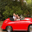

In [10]:
img

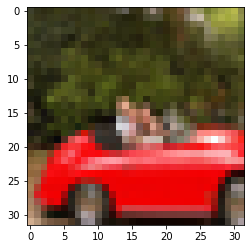

In [9]:
plt.imshow(img)

## Transforming the data 

In [11]:
# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [12]:
# Applying a transform
tensor_cifar10 = CIFAR10(BASE_DIR, train=True, download=False,
                         transform=transforms.Compose(
                             [ transforms.ToTensor(),
                               transforms.Normalize(
                                  (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
                               )
                             ]
                         ))
tensor_test_cifar10 = CIFAR10(BASE_DIR, train=False, download=False,
                         transform=transforms.Compose(
                             [ transforms.ToTensor(),
                               transforms.Normalize(
                                  (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
                               )
                             ]
                         ))


In [ ]:
# tuple (tensor, label)
tensor_img = tensor_cifar10[99][0]

In [ ]:
tensor_img.shape

In [ ]:
plt.imshow(tensor_img.permute(1, 2, 0))

In [ ]:
# Normalizing data
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

In [ ]:
imgs.view(3, -1).mean(dim=1)

In [ ]:
imgs.view(3, -1).std(dim=1)

In [15]:
tensor_img.shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


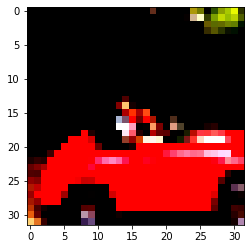

In [14]:
# After Normalization
tensor_img = tensor_cifar10[99][0]
plt.imshow(tensor_img.permute(1, 2, 0))

In [16]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in tensor_cifar10
          if label in [0, 2]]
cifar2_test = [(img, label_map[label])
              for img, label in tensor_test_cifar10
              if label in [0, 2]]

## Dataset Loaders

In [20]:
batch_size = 64
train_loader = DataLoader(cifar2, batch_size=batch_size, shuffle=True)
# we'll cover the test set only once
test_loader = DataLoader(cifar2_test, batch_size=batch_size, shuffle=False)

## Build Neural network Model

In [21]:
out_dim = 2
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, out_dim)
).to(device)

In [22]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Training Loop

In [23]:
n_epochs = 100
losses = {"train loss": []}
loop = tqdm(range(n_epochs))

for epoch in loop:
  loss_train = 0
  for imgs, labels in train_loader:
    
    imgs = imgs.to(device)
    labels = labels.to(device)

    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    loss = loss_fn(outputs, labels)
    loss_train += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 10 == 0:
    lt = loss_train / len(train_loader)
    print("Epoch: %d, Loss: %f" % (epoch, lt))
    losses["train loss"].append(lt)


Epoch: 0, Loss: 0.504529
Epoch: 10, Loss: 0.369781
Epoch: 20, Loss: 0.293154
Epoch: 30, Loss: 0.208382
Epoch: 40, Loss: 0.141441
Epoch: 50, Loss: 0.089780
Epoch: 60, Loss: 0.057825
Epoch: 70, Loss: 0.038769
Epoch: 80, Loss: 0.028485
Epoch: 90, Loss: 0.021026



In [24]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

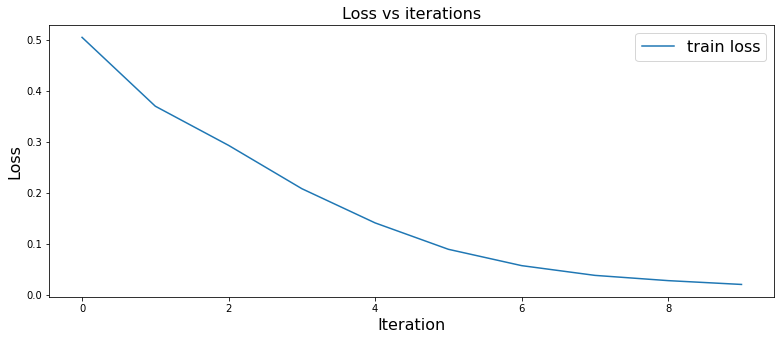

In [25]:
plot_losses(losses)

## Evaluating the Model

In [26]:
correct = 0
total = 0

with torch.no_grad():
  for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    _, predicted = torch.max(outputs, 1)
    total += labels.shape[0]
    correct += int((predicted == labels).sum())

print("Accuracy: %f", correct / total)

Accuracy: %f 0.822


## Applying the model to new Data

In [27]:
from PIL import Image

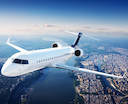

In [28]:
plane = Image.open(get_path("aviao.jpg"))
plane

In [29]:
prep_transforms = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize( (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616) )
     ]
)
plane_tensor = prep_transforms(plane)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


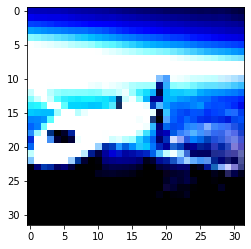

In [30]:
plt.imshow(plane_tensor.permute(1,2, 0))

In [31]:
batch = plane_tensor.unsqueeze(0).to(device)

In [32]:
batch.shape

torch.Size([1, 3, 32, 32])

In [33]:
model.eval()

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
)

In [34]:
output = model(batch.view(-1))
output

tensor([ 4.1601, -4.1277], device='cuda:0', grad_fn=<AddBackward0>)

In [35]:
logits = torch.nn.functional.softmax(output, dim=0) * 100
print(f"Plane score: {logits[0].item()}\n Bird score: {logits[1].item()}")

Plane score: 99.974853515625
 Bird score: 0.025148777291178703


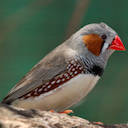

In [36]:
bird = Image.open(get_path("passaro.jpg"))
bird

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


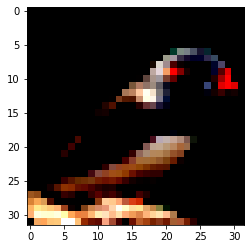

In [37]:
bird_tensor = prep_transforms(bird)
plt.imshow(bird_tensor.permute(1, 2, 0))

In [38]:
batch = bird_tensor.unsqueeze(0).to(device)

In [39]:
output = model(batch.view(-1))
output

tensor([-5.7421,  5.3987], device='cuda:0', grad_fn=<AddBackward0>)

In [40]:
logits = torch.nn.functional.softmax(output, dim=0) * 100
print(f"Plane score: {logits[0].item()}\n Bird score: {logits[1].item()}")

Plane score: 0.001450760057196021
 Bird score: 99.99854278564453
